In [67]:
import functools

from dm_control import composer
from dm_control.composer.variation import distributions
from dm_control.locomotion.arenas import bowl
from dm_control.locomotion.arenas import corridors as corr_arenas
from dm_control.locomotion.arenas import floors
from dm_control.locomotion.arenas import labmaze_textures
from dm_control.locomotion.arenas import mazes
from dm_control.locomotion.props import target_sphere
from dm_control.locomotion.tasks import corridors as corr_tasks
from dm_control.locomotion.tasks import escape
from dm_control.locomotion.tasks import random_goal_maze
from dm_control.locomotion.tasks import reach
from dm_control.locomotion.walkers import rodent

"""
appendages_pos (15): head and 4 paw positions, projected to egocentric frame, and reshaped to 1D
joints_pos/vel (30): angle and angular velocity of the 1D hinge joints
tendons_pos/vel (8): extension and extension velocity of the 1D tendons
sensors_accelerometer/velocimeter/gyro (3): Acceleration/velocity/angular velocity of the body
world_zaxis (3): the world's z-vector (-gravity) in this Walker's torso frame
sensors_touch (4): touch sensors (forces) in the 4 paws
"""
RODENT_PROPRIOCEPTION_ATTRIBUTES = ('appendages_pos', 'joints_pos', 'joints_vel', 'tendons_pos', 
                                    'tendons_vel', 'sensors_accelerometer', 'sensors_velocimeter', 
                                    'sensors_gyro', 'sensors_touch', 'world_zaxis')

random_state=None
physics_dt=0.002
ctrl_dt=0.02

In [68]:
class RunThroughCorridor2(corr_tasks.RunThroughCorridor):
    def get_reward(self, physics):
        walker_xvel = physics.bind(self._walker.root_body).subtree_linvel[0]
        xvel_term = rewards.tolerance(
            walker_xvel, (self._vel, self._vel),
            margin=self._vel,
            sigmoid='linear',
            value_at_margin=0.0)
        return xvel_term

In [99]:
walker.root_body.pos

array([3.09952605e-02, 2.05852494e-07, 6.50895726e-02])

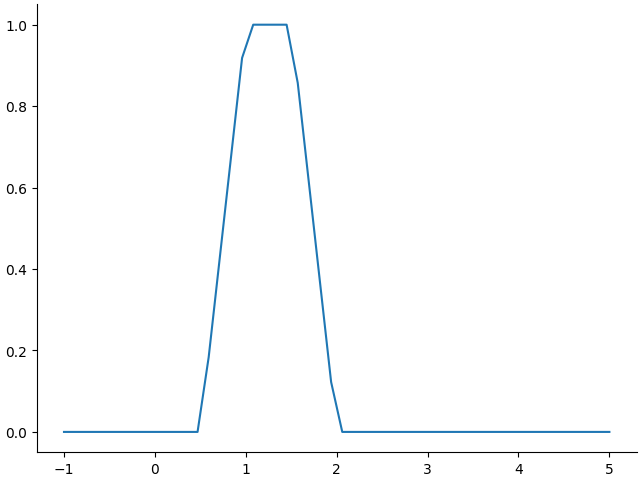

In [95]:
from dm_control.utils import rewards
x = np.linspace(-1, 5)
y = rewards.tolerance(x, (1, 1.5), margin=0.5, sigmoid='linear', value_at_margin=0)
plt.plot(x, y)

In [69]:
# Build a position-controlled rodent walker.
walker = rodent.Rat(
  observable_options={'egocentric_camera': dict(enabled=True)})

In [70]:
# Build a corridor-shaped arena with gaps, where the sizes of the gaps and
# platforms are uniformly randomized.
arena = corr_arenas.GapsCorridor(
  platform_length=distributions.Uniform(.4, .8),
  gap_length=distributions.Uniform(.05, .2),
  corridor_width=2,
  corridor_length=40,
  aesthetic='outdoor_natural')

In [71]:
# Build a task that rewards the agent for running down the corridor at a
# specific velocity.
# task = corr_tasks.RunThroughCorridor(
task = RunThroughCorridor2(
  walker=walker,
  arena=arena,
  walker_spawn_position=(5, 0, 0),
  walker_spawn_rotation=0,
  target_velocity=1.0,
  contact_termination=True,
  terminate_at_height=-0.3,
  physics_timestep=physics_dt,
  control_timestep=ctrl_dt)

In [72]:
env = composer.Environment(time_limit=30,
                          task=task,
                          random_state=random_state,
                          strip_singleton_obs_buffer_dim=True)
propri_attr = RODENT_PROPRIOCEPTION_ATTRIBUTES

In [73]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [74]:
from virtual_rodent.environment import MAPPER
from virtual_rodent import VISION_DIM, PROPRI_DIM, ACTION_DIM
from virtual_rodent.network.vision_enc import ResNet18Enc
from virtual_rodent.network.propri_enc import MLPEnc
import virtual_rodent.network.Merel2019 as Merel2019
from virtual_rodent.utils import load_checkpoint

In [75]:
vision_enc = ResNet18Enc()
vision_emb_dim = vision_enc.get_emb_dim(VISION_DIM)

propri_emb_dim = 20 # propri_dim
propri_enc = MLPEnc(PROPRI_DIM[0], propri_emb_dim, hidden_dims=(50,))

critic_in_dim = vision_emb_dim + propri_emb_dim
critic = Merel2019.Critic(critic_in_dim)

actor_in_dim = critic_in_dim + PROPRI_DIM[0] + critic.hidden_dim
actor = Merel2019.Actor(actor_in_dim, ACTION_DIM, logit_scale=1)

model = Merel2019.MerelModel(vision_enc, propri_enc, VISION_DIM, PROPRI_DIM, 
                             actor, critic, ACTION_DIM) 

In [76]:
# env_name = 'gaps'
# env, propri_attr = MAPPER[env_name](physics_dt=0.001, ctrl_dt=0.02)

In [77]:
from virtual_rodent.visualization import video
from virtual_rodent.simulation import simulate
ext_cam = (0,)
save_dir = './'
ext_cam_size = (200, 200)
with torch.no_grad():
    ret = simulate(env, model, propri_attr, max_step=100, device=torch.device('cpu'), ext_cam=ext_cam)
for i in ext_cam:
    anim = video(ret['cam%d'%i])
    fname = 'demo_%s_cam%d.gif' % ('gaps', i)
    anim.save(os.path.join(save_dir, fname), writer='pillow')

[-0.15027781  0.01974944  0.02018559]


AssertionError: 